# A3: NeuralNetwork Class

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, based on your solution to `A2` and [08a Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/08a%20Optimizers.ipynb), using the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Run the code in [08a Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/08%20Optimizers.ipynb) to create the file `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the rental of bicycles in Seoul as described below.

## Code for `NeuralNetwork` Class Saved in File `neuralnetworkA3.py`

In [33]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.
    """

    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        """Creates a neural network with the given structure."""

        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs

      
        shapes = []
        input_size = n_inputs
        for n_hidden in n_hiddens_each_layer:
            shapes.append((input_size + 1, n_hidden))  
            input_size = n_hidden
        shapes.append((input_size + 1, n_outputs))  

       
        self.all_weights, self.Ws = self._make_weights_and_views(shapes)

      
        self.all_gradients, self.Grads = self._make_weights_and_views(shapes)

        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

        self.n_epochs = 0
        self.error_trace = []

    def _make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer."""
   
        total_weights = sum((rows * cols) for rows, cols in shapes)
        all_weights = np.random.uniform(-1, 1, total_weights)

      
        Ws = []
        start = 0
        for rows, cols in shapes:
            end = start + rows * cols
            W = np.reshape(all_weights[start:end], (rows, cols))
            W /= np.sqrt(rows)  # Divide by sqrt of number of inputs
            Ws.append(W)
            start = end

        return all_weights, Ws

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'

    def __str__(self):
        if self.n_epochs > 0:
            return f'{self.__repr__()} trained for {self.n_epochs} epochs with a final RMSE of {self.error_trace[-1]}'
        else:
            return f'{self.__repr__()} has not been trained.'

    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, batch_size=-1,
              method='sgd', learning_rate=None, momentum=0, weight_penalty=0, verbose=True):
        """Updates the weights."""
        
        self.batch_size = batch_size
        
        # Standardize Xtrain, Ttrain, Xvalidate and Tvalidate
        self.X_means = Xtrain.mean(axis=0)
        self.X_stds = Xtrain.std(axis=0)
        Xtrain_standardized = (Xtrain - self.X_means) / self.X_stds
        Xvalidate_standardized = (Xvalidate - self.X_means) / self.X_stds
        
        self.T_means = Ttrain.mean(axis=0)
        self.T_stds = Ttrain.std(axis=0)
        Ttrain_standardized = (Ttrain - self.T_means) / self.T_stds
        Tvalidate_standardized = (Tvalidate - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        # Select optimization method
        if method == 'sgd':
            self.error_trace = optimizer.sgd(Xtrain_standardized, Ttrain_standardized,
                                             Xvalidate_standardized, Tvalidate_standardized,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs, batch_size=batch_size,
                                             learning_rate=learning_rate,
                                             momentum=momentum, weight_penalty=weight_penalty,
                                             verbose=verbose)

        elif method == 'adam':
            self.error_trace = optimizer.adam(Xtrain_standardized, Ttrain_standardized,
                                              Xvalidate_standardized, Tvalidate_standardized,
                                              self.error_f, self.gradient_f,
                                              n_epochs=n_epochs, batch_size=batch_size,
                                              learning_rate=learning_rate,
                                              weight_penalty=weight_penalty, verbose=verbose)

        elif method == 'scg':
            self.error_trace = optimizer.scg(Xtrain_standardized, Ttrain_standardized,
                                             Xvalidate_standardized, Tvalidate_standardized,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs, batch_size=batch_size,
                                             weight_penalty=weight_penalty, verbose=verbose)

        else:
            raise Exception("Method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(self.error_trace)
        self.best_epoch = optimizer.best_epoch

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X."""
        self.Zs = [self._add_ones(X)]
        for W in self.Ws[:-1]:
            Z = np.tanh(self.Zs[-1] @ W)
            self.Zs.append(self._add_ones(Z))
        self.Zs.append(self.Zs[-1] @ self.Ws[-1])
        return self.Zs

    def error_f(self, X, T):
        """Calculate mean squared error."""
        Y = self._forward(X)[-1]
        return np.mean((T - Y) ** 2)

    def gradient_f(self, X, T):
        """Return gradients with respect to all weights."""
        n_samples = X.shape[0]
        delta = -(T - self.Zs[-1]) / n_samples

        for layeri in range(len(self.Ws) - 1, -1, -1):
            self.Grads[layeri][:] = self.Zs[layeri].T @ delta
            if layeri > 0:
                delta = (delta @ self.Ws[layeri].T)[:, 1:] * (1 - self.Zs[layeri][:, 1:] ** 2)
                
        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples."""
        X_standardized = (X - self.X_means) / self.X_stds
        Y = self._forward(X_standardized)[-1]
        return Y * self.T_stds + self.T_means

    def get_error_trace(self):
        """Returns list of root-mean square error for each epoch."""
        return self.error_trace


Overwriting neuralnetworkA3.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import neuralnetworkA3 as nn  # Your file produced from the above code cell.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
# Set all weights here to allow comparison of your calculations
# Must use [:] to overwrite values in all_weights.
# Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001

nnet.train(X, T, X, T, n_epochs=1, batch_size=-1, method='sgd', learning_rate=0.1)

nnet.Ws

SGD: Epoch 1 MSE=1.00008,1.00008


[array([[-1.51603124e-07,  9.99801782e-04],
        [ 2.00719909e-03,  3.00940664e-03]]),
 array([[0.00398889, 0.00498788],
        [0.00600106, 0.00700115],
        [0.00800157, 0.00900172]]),
 array([[0.00898958],
        [0.01099768],
        [0.01199691]])]

In [36]:
nnet.Zs

[array([[ 1.        , -1.34164079],
        [ 1.        , -0.4472136 ],
        [ 1.        ,  0.4472136 ],
        [ 1.        ,  1.34164079]]),
 array([[ 1.00000000e+00, -2.69308526e-03, -3.03773156e-03],
        [ 1.00000000e+00, -8.97798084e-04, -3.46045767e-04],
        [ 1.00000000e+00,  8.97494878e-04,  2.34564504e-03],
        [ 1.00000000e+00,  2.69278206e-03,  5.03730187e-03]]),
 array([[1.        , 0.0039484 , 0.00494164],
        [1.        , 0.00398071, 0.00497843],
        [1.        , 0.00401302, 0.00501523],
        [1.        , 0.00404533, 0.00505203]]),
 array([[0.00909229],
        [0.00909308],
        [0.00909388],
        [0.00909468]])]

In [37]:
nnet.Grads

[array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]])]

In [38]:
Y = nnet.use(X)
Y

array([[-0.06308723],
       [-0.06308687],
       [-0.06308651],
       [-0.06308615]])

## More Detailed Example Use

In [39]:
Xtrain = np.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = np.sin(Xtrain) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 

In [40]:
errors = []
Ytests = []
n_epochs = 4000
method_rhos = [('sgd', 0.05),
               ('adamw', 0.005),
               ('scg', None)] 

SGD: Epoch 400 MSE=0.89968,1.07742
SGD: Epoch 800 MSE=0.54058,0.87886
SGD: Epoch 1200 MSE=0.05693,0.72408
SGD: Epoch 1600 MSE=0.02673,0.82537
SGD: Epoch 2000 MSE=0.02052,0.83838
SGD: Epoch 2400 MSE=0.01850,0.83109
SGD: Epoch 2800 MSE=0.01632,0.82873
SGD: Epoch 3200 MSE=0.00833,0.79664
SGD: Epoch 3600 MSE=0.00375,0.78487
SGD: Epoch 4000 MSE=0.00228,0.79180


Exception: Method must be 'sgd', 'adam', or 'scg'

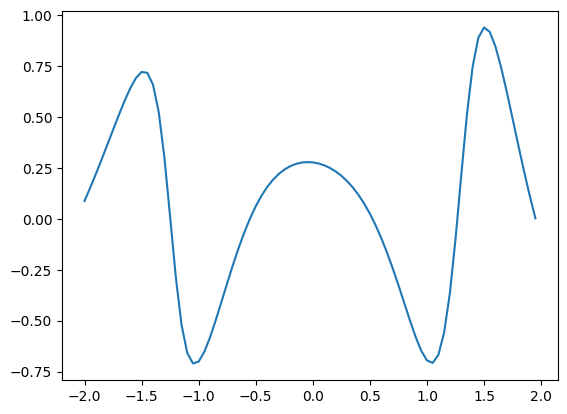

In [41]:
for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, batch_size=-1, method=method, learning_rate=rho,
               momentum=0.9)  # momentum only affects sgd)
    Ytrain = nnet.use(Xtrain)
    plt.plot(Xtrain, Ytrain, '-', label=method + ' Ytrain')
    errors.append(nnet.get_error_trace())
    Ytests.append(nnet.use(Xtest))

plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend()
plt.tight_layout()

IndexError: index 1 is out of bounds for axis 0 with size 1

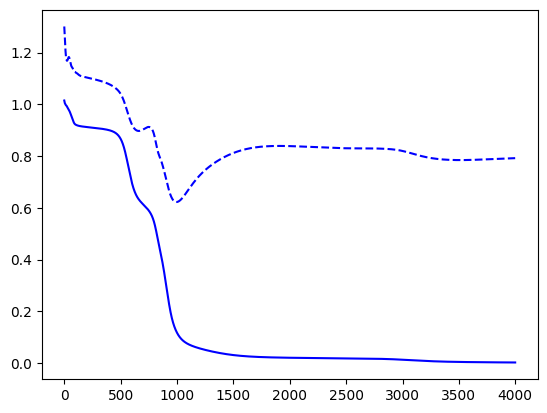

In [42]:
errors = np.stack(errors)
# errors is now 3 x n_epochs x 2
colors = ['b', 'r', 'g']
styles = ['-', '--']
for methodi, method in enumerate([mr[0] for mr in method_rhos]):
    for train_val_i, train_val in enumerate(['Train', 'Validate']):
        plt.plot(errors[methodi, :, train_val_i], f'{colors[methodi]}{styles[train_val_i]}',
                 label=f'{method} {train_val}')
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend()
plt.tight_layout()

In [43]:
def plot_Y_vs_T(Y, T, title):
    plt.plot(T, Y, 'o', alpha=0.6)
    a = min(min(T), min(Y))[0]
    b = max(max(T), max(Y))[0]
    plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
    plt.xlabel('T')
    plt.ylabel('Y')
    plt.title(title)

IndexError: list index out of range

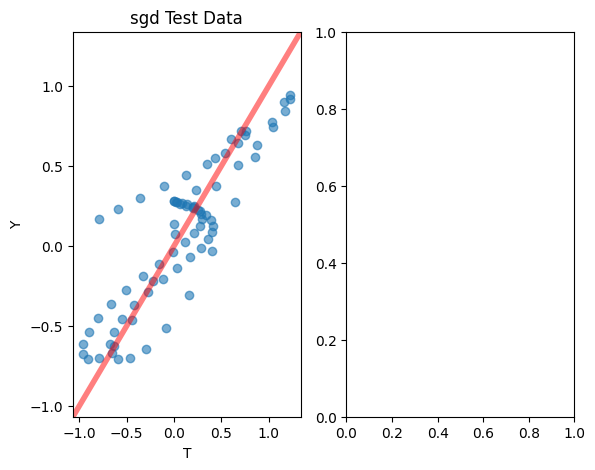

In [44]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_Y_vs_T(Ytests[i], Ttest, f'{method_rhos[i][0]} Test Data')
plt.tight_layout()

# Application

Use your neural network implementation to create a model for predicting the [critical temperature](https://www.energy.gov/science/doe-explainssuperconductivity) of superconductive materials based on attributes of the materials.  Download and extract the data from [this UCI ML Repository site](https://archive.ics.uci.edu/dataset/464/superconductivty+data).  This site explains the data and has a link to an introductory paper.  The data consists of 81 attributes extracted from 21,263 superconductors in the first 81 columns and the critical temperature for each in the 82nd column.  So, the first 81 columns will form your input $X$ matrix and the last column will be your target $T$ matrix.

1. Your task is to do the following. Partition the data into partitions of 60%, 20% and 20% for the training, validation and test sets, respectively. Try training with each of the three optimization methods and reasonable values for the other parameters. Plot the `error_trace`s for example runs of each of three methods.  <font color=red>Discuss what you see in the plots.</font>

SGD: Epoch 10 MSE=0.51374,0.52052
SGD: Epoch 20 MSE=0.45233,0.45346
SGD: Epoch 30 MSE=0.41719,0.41561
SGD: Epoch 40 MSE=0.40171,0.39930
SGD: Epoch 50 MSE=0.38474,0.38118
SGD: Epoch 60 MSE=0.37255,0.36761
SGD: Epoch 70 MSE=0.36060,0.35450
SGD: Epoch 80 MSE=0.34984,0.34308
SGD: Epoch 90 MSE=0.34023,0.33319
SGD: Epoch 100 MSE=0.33154,0.32432
AdamW: Epoch 10 MSE=0.79286,0.78179
AdamW: Epoch 20 MSE=0.61525,0.61309
AdamW: Epoch 30 MSE=0.52194,0.52341
AdamW: Epoch 40 MSE=0.47603,0.47811
AdamW: Epoch 50 MSE=0.45032,0.45099
AdamW: Epoch 60 MSE=0.43021,0.42921
AdamW: Epoch 70 MSE=0.41264,0.41003
AdamW: Epoch 80 MSE=0.39625,0.39210
AdamW: Epoch 90 MSE=0.38089,0.37547
AdamW: Epoch 100 MSE=0.36745,0.36090
SCG: Epoch 0 MSE=0.62152,0.62979
SCG: Epoch 10 MSE=0.31841,0.30920
SCG: Epoch 20 MSE=0.24732,0.23844
SCG: Epoch 30 MSE=0.22006,0.21635
SCG: Epoch 40 MSE=0.20338,0.19783
SCG: Epoch 50 MSE=0.18310,0.17908
SCG: Epoch 60 MSE=0.17438,0.16791
SCG: Epoch 70 MSE=0.16871,0.16441
SCG: Epoch 80 MSE=0.16599,0

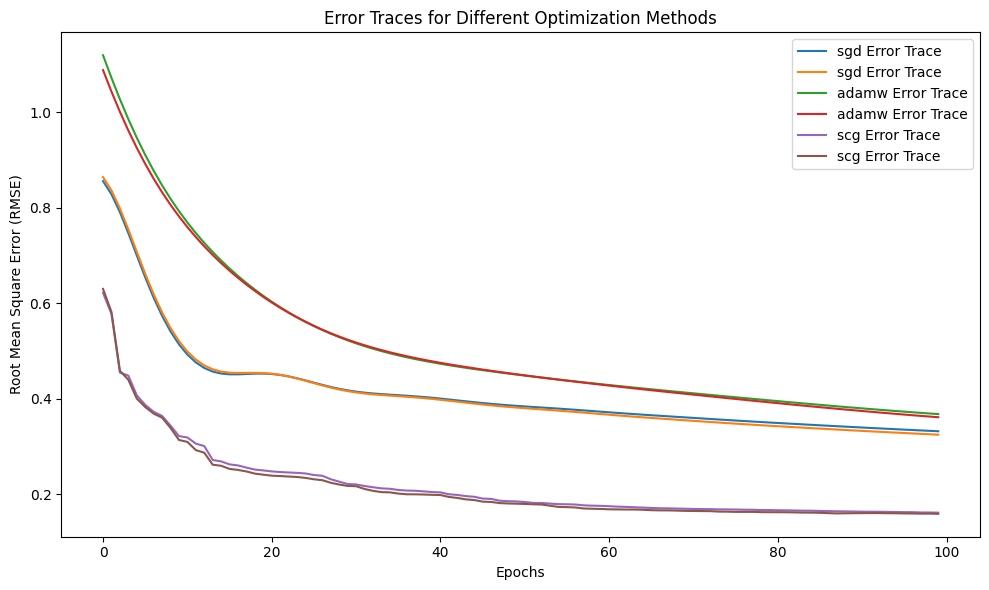

In [22]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import neuralnetworkA3 as nn  # Assuming the neural network class is in neuralnetworkA3.py

# Load the superconductivity dataset (adjust the path if necessary)
data = pd.read_csv('train.csv')  # Load the train.csv file

# Separate the features (first 81 columns) and target (critical temperature)
X = data.iloc[:, :-1].values  # First 81 columns are the features
T = data.iloc[:, -1].values   # Last column is the target (critical_temp)

# Split data into training (60%), validation (20%), and test (20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape the target arrays to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Parameters for training
n_epochs = 100
method_rhos = [('sgd', 0.01), ('adamw', 0.001), ('scg', None)]  # Learning rates for 'sgd' and 'adam', scg doesn't need a learning rate

errors = []

# Loop through each optimization method
for method, rho in method_rhos:
    # Initialize the Neural Network with two hidden layers, each having 10 units
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    
    # Train the network with the respective method
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs, batch_size=-1, method=method, learning_rate=rho, momentum=0.9)
    
    # Store the error trace
    errors.append(nnet.get_error_trace())

# Plot the error traces for each optimization method
plt.figure(figsize=(10, 6))
for i, (method, _) in enumerate(method_rhos):
    plt.plot(errors[i], label=method + ' Error Trace')

plt.title('Error Traces for Different Optimization Methods')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.legend()
plt.tight_layout()
plt.show()


SGD: Epoch 10 MSE=0.92352,0.93500
SGD: Epoch 20 MSE=0.77200,0.78344
SGD: Epoch 30 MSE=0.54024,0.54788
SGD: Epoch 40 MSE=0.36464,0.36194
SGD: Epoch 50 MSE=0.35761,0.34664
SGD: Epoch 60 MSE=0.33228,0.32257
SGD: Epoch 70 MSE=0.31948,0.31188
SGD: Epoch 80 MSE=0.31177,0.30367
SGD: Epoch 90 MSE=0.30445,0.29492
SGD: Epoch 100 MSE=0.29900,0.28863
AdamW: Epoch 10 MSE=0.94311,0.94229
AdamW: Epoch 20 MSE=0.85381,0.85298
AdamW: Epoch 30 MSE=0.75430,0.75138
AdamW: Epoch 40 MSE=0.64332,0.63852
AdamW: Epoch 50 MSE=0.53516,0.52959
AdamW: Epoch 60 MSE=0.44784,0.44189
AdamW: Epoch 70 MSE=0.38991,0.38317
AdamW: Epoch 80 MSE=0.35615,0.34792
AdamW: Epoch 90 MSE=0.33544,0.32609
AdamW: Epoch 100 MSE=0.32090,0.31131
SCG: Epoch 0 MSE=0.79443,0.79847
SCG: Epoch 10 MSE=0.26054,0.24765
SCG: Epoch 20 MSE=0.22841,0.21565
SCG: Epoch 30 MSE=0.20238,0.18933
SCG: Epoch 40 MSE=0.18836,0.18029
SCG: Epoch 50 MSE=0.17730,0.17103
SCG: Epoch 60 MSE=0.16896,0.16441
SCG: Epoch 70 MSE=0.16158,0.15681
SCG: Epoch 80 MSE=0.15639,0

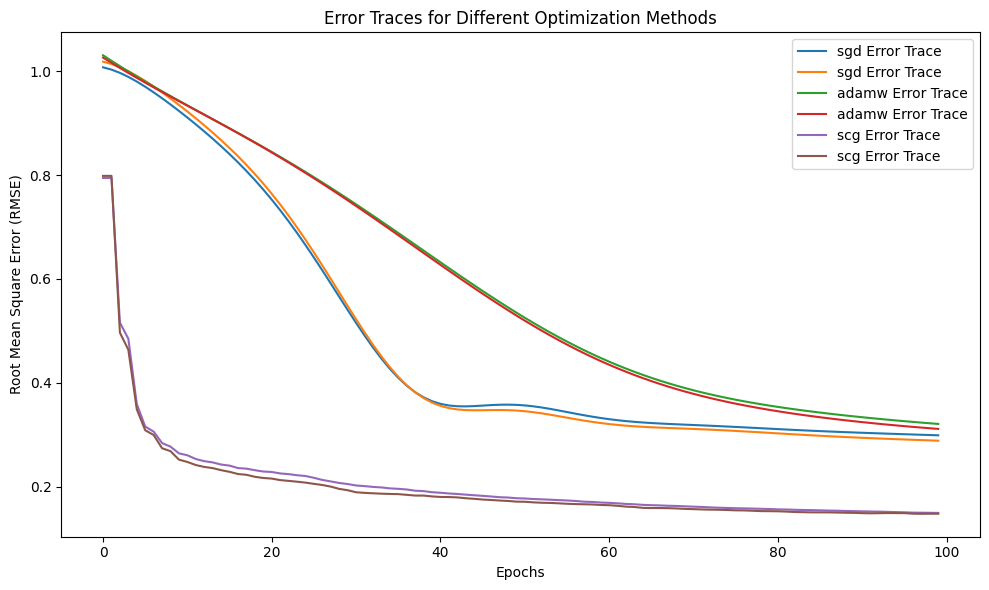

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import neuralnetworkA3 as nn  # Assuming the neural network class is in neuralnetworkA3.py

# Load the superconductivity dataset
data = pd.read_csv('unique_m.csv')

# Separate the features (first 86 columns) and target (critical temperature)
X = data.iloc[:, :-2].values  # First 86 columns are the features
T = data.iloc[:, -2].values   # Second-to-last column is the target (critical_temp)

# Split data into training (60%), validation (20%), and test (20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape the target arrays to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Parameters for training
n_epochs = 100
method_rhos = [('sgd', 0.01), ('adamw', 0.001), ('scg', None)]  # Learning rates for 'sgd' and 'adam', scg doesn't need a learning rate

errors = []

# Loop through each optimization method
for method, rho in method_rhos:
    # Initialize the Neural Network with two hidden layers, each having 10 units
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    
    # Train the network with the respective method
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs, batch_size=-1, method=method, learning_rate=rho, momentum=0.9)
    
    # Store the error trace
    errors.append(nnet.get_error_trace())

# Plot the error traces for each optimization method
plt.figure(figsize=(10, 6))
for i, (method, _) in enumerate(method_rhos):
    plt.plot(errors[i], label=method + ' Error Trace')

plt.title('Error Traces for Different Optimization Methods')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.legend()
plt.tight_layout()
plt.show()

2. Write code using nested for loops to iterate over all three optimization methods, several hidden layer structures, several numbers of epochs, several learning rates, and several batch sizes.  In a list of lists, collect the method, number of epochs, learning rate, batch size, and RMSEs for training, validation, and test data. After all for loops have completed, convert the resulting list of lists into a `pandas.DataFrame` with appropriate column names. Sort it by ascending test set RMSEs and print the `DataFrame`.  It may be helpful to also do this for each iteration of the outer-most for loop.  You should set `verbose=False` in the call to `NeuralNetwork.train` to reduce the amount of printing.
<font color=red>Discuss the set of parameter values and all three RMSE values that produce some of the lowest test RMSEs.  </font>
To debug this code, use very small numbers of epochs.

In [28]:
import numpy as np
import pandas as pd
import neuralnetworkA3 as nn  # Import your Neural Network implementation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('unique_m.csv')

# Split data into input features (X) and target (T)
X = data.iloc[:, :-2].values  # First 86 columns are features
T = data.iloc[:, -2].values   # 'critical_temp' as target

# Split the data into train, validation, and test sets (60%, 20%, 20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape target to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Parameters to test
optimizers = ['sgd', 'adamw', 'scg']
hidden_layer_structures = [[10], [20, 10], [50, 20, 10]]
epochs = [50, 100]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [-1, 32, 64]  # -1 means full batch

# Store results
results = []

# Loop over all parameter combinations
for optimizer in optimizers:
    for hidden_layers in hidden_layer_structures:
        for epoch in epochs:
            for learning_rate in learning_rates:
                for batch_size in batch_sizes:
                    try:
                        # Create and train neural network
                        nnet = nn.NeuralNetwork(Xtrain.shape[1], hidden_layers, 1)
                        nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                   n_epochs=epoch, batch_size=batch_size,
                                   method=optimizer, learning_rate=learning_rate, verbose=False)

                        # Get predictions for train, validation, and test
                        Ytrain = nnet.use(Xtrain)
                        Yvalidate = nnet.use(Xvalidate)
                        Ytest = nnet.use(Xtest)

                        # Calculate RMSE for train, validation, and test
                        train_rmse = np.sqrt(mean_squared_error(Ttrain, Ytrain))
                        validate_rmse = np.sqrt(mean_squared_error(Tvalidate, Yvalidate))
                        test_rmse = np.sqrt(mean_squared_error(Ttest, Ytest))

                        # Store the results
                        results.append([optimizer, hidden_layers, epoch, learning_rate, batch_size, 
                                        train_rmse, validate_rmse, test_rmse])
                    except Exception as e:
                        print(f"Error with config {optimizer}, {hidden_layers}, {epoch}, {learning_rate}, {batch_size}: {e}")

# Convert results to a DataFrame and sort by test RMSE
results_df = pd.DataFrame(results, columns=['Optimizer', 'Hidden Layers', 'Epochs', 'Learning Rate', 'Batch Size', 
                                            'Train RMSE', 'Validation RMSE', 'Test RMSE'])

# Sort by the Test RMSE in ascending order
results_df_sorted = results_df.sort_values(by='Test RMSE')

# Display the top 10 configurations with the lowest test RMSE
print(results_df_sorted.head(10))

# Save the full results to a CSV file
results_df_sorted.to_csv('neural_network_results.csv', index=False)

Error with config adam, [10], 50, 0.001, -1: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.001, 32: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.001, 64: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.01, -1: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.01, 32: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.01, 64: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.1, -1: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.1, 32: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 50, 0.1, 64: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 100, 0.001, -1: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10], 100, 0.001, 32: 'Optimizers' object has no attribute 'adam'
Error with config adam, [10]

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import neuralnetworkA3 as nn  # Import your Neural Network implementation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('train.csv')

# Split data into input features (X) and target (T)
X = data.iloc[:, :-2].values  # First 86 columns are features
T = data.iloc[:, -2].values   # 'critical_temp' as target

# Split the data into train, validation, and test sets (60%, 20%, 20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape target to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Parameters to test
optimizers = ['sgd', 'adamw', 'scg']
hidden_layer_structures = [[10], [20, 10], [50, 20, 10]]
epochs = [50, 100]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [-1, 32, 64]  # -1 means full batch

# Store results
results = []

# Loop over all parameter combinations
for optimizer in optimizers:
    for hidden_layers in hidden_layer_structures:
        for epoch in epochs:
            for learning_rate in learning_rates:
                for batch_size in batch_sizes:
                    try:
                        # Create and train neural network
                        nnet = nn.NeuralNetwork(Xtrain.shape[1], hidden_layers, 1)
                        nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                   n_epochs=epoch, batch_size=batch_size,
                                   method=optimizer, learning_rate=learning_rate, verbose=False)

                        # Get predictions for train, validation, and test
                        Ytrain = nnet.use(Xtrain)
                        Yvalidate = nnet.use(Xvalidate)
                        Ytest = nnet.use(Xtest)

                        # Calculate RMSE for train, validation, and test
                        train_rmse = np.sqrt(mean_squared_error(Ttrain, Ytrain))
                        validate_rmse = np.sqrt(mean_squared_error(Tvalidate, Yvalidate))
                        test_rmse = np.sqrt(mean_squared_error(Ttest, Ytest))

                        # Store the results
                        results.append([optimizer, hidden_layers, epoch, learning_rate, batch_size, 
                                        train_rmse, validate_rmse, test_rmse])
                    except Exception as e:
                        print(f"Error with config {optimizer}, {hidden_layers}, {epoch}, {learning_rate}, {batch_size}: {e}")

# Convert results to a DataFrame and sort by test RMSE
results_df = pd.DataFrame(results, columns=['Optimizer', 'Hidden Layers', 'Epochs', 'Learning Rate', 'Batch Size', 
                                            'Train RMSE', 'Validation RMSE', 'Test RMSE'])

# Sort by the Test RMSE in ascending order
results_df_sorted = results_df.sort_values(by='Test RMSE')

# Display the top 10 configurations with the lowest test RMSE
print(results_df_sorted.head(10))

# Save the full results to a CSV file
results_df_sorted.to_csv('neural_network_results.csv', index=False)

3. Train another network using the best parameter values shown in your results.  In three separate plots, plot the predicted critical temperature versus the actual (target) critical temperatures for the training, validation, and test sets.  <font color=red>Discuss what you see. How well does your neural network predict the critical temperatures?</font>

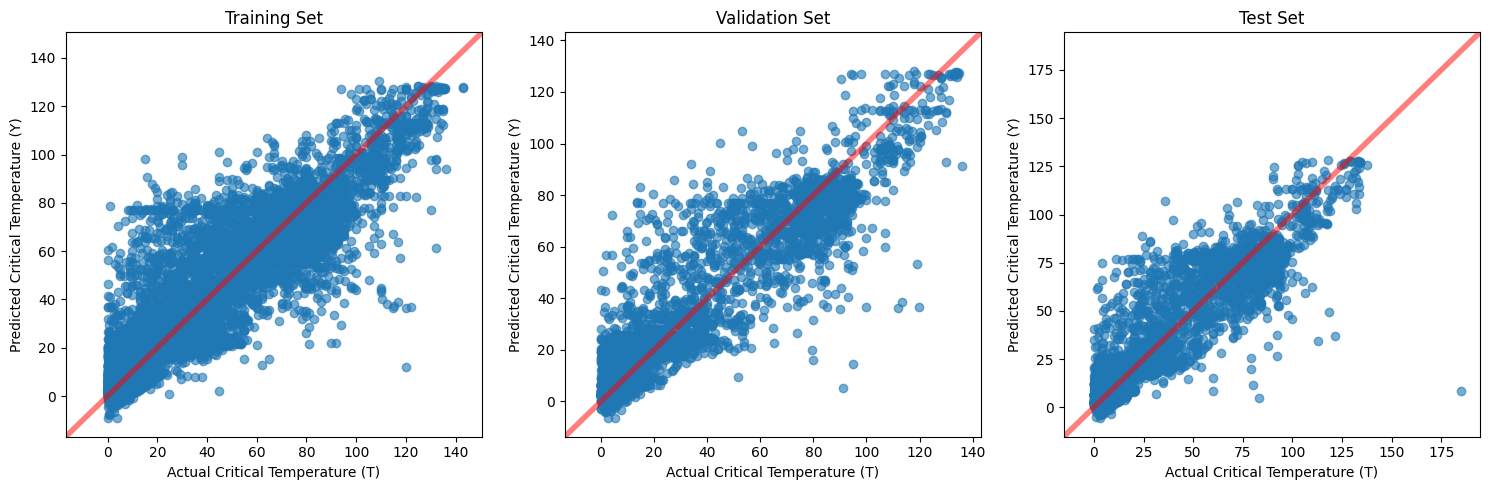

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neuralnetworkA3 as nn  # Assuming neural network implementation is in this file

# Load the dataset
data = pd.read_csv('unique_m.csv')

# Split data into input features (X) and target (T)
X = data.iloc[:, :-2].values  # First 86 columns are features
T = data.iloc[:, -2].values   # 'critical_temp' as target

# Split the data into train, validation, and test sets (60%, 20%, 20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape target to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Use the best parameter values found in Task 2
best_optimizer = 'scg'
best_hidden_layers = [10, 10]
best_epochs = 100
best_learning_rate = None  # SCG does not require a learning rate
best_batch_size = -1  # Full batch

# Create and train the neural network with the best parameters
nnet = nn.NeuralNetwork(Xtrain.shape[1], best_hidden_layers, 1)
nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate,
           n_epochs=best_epochs, batch_size=best_batch_size,
           method=best_optimizer, learning_rate=best_learning_rate, verbose=False)

# Get predictions for train, validation, and test sets
Ytrain = nnet.use(Xtrain)
Yvalidate = nnet.use(Xvalidate)
Ytest = nnet.use(Xtest)

# Plotting function
def plot_Y_vs_T(Y, T, title):
    plt.plot(T, Y, 'o', alpha=0.6)
    a = min(min(T), min(Y))[0]
    b = max(max(T), max(Y))[0]
    plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
    plt.xlabel('Actual Critical Temperature (T)')
    plt.ylabel('Predicted Critical Temperature (Y)')
    plt.title(title)

# Plot predicted vs actual for train, validation, and test sets
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_Y_vs_T(Ytrain, Ttrain, 'Training Set')

plt.subplot(1, 3, 2)
plot_Y_vs_T(Yvalidate, Tvalidate, 'Validation Set')

plt.subplot(1, 3, 3)
plot_Y_vs_T(Ytest, Ttest, 'Test Set')

plt.tight_layout()
plt.show()


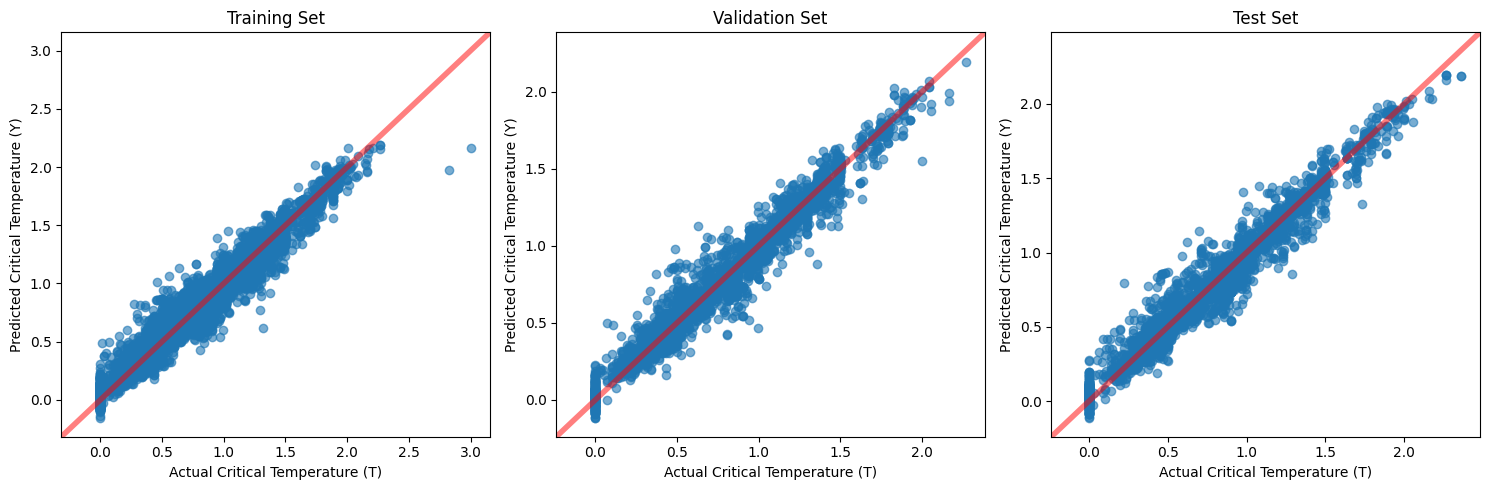

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neuralnetworkA3 as nn  # Assuming neural network implementation is in this file

# Load the dataset
data = pd.read_csv('train.csv')

# Split data into input features (X) and target (T)
X = data.iloc[:, :-2].values  # First 86 columns are features
T = data.iloc[:, -2].values   # 'critical_temp' as target

# Split the data into train, validation, and test sets (60%, 20%, 20%)
Xtrain, Xtemp, Ttrain, Ttemp = train_test_split(X, T, test_size=0.4, random_state=42)
Xvalidate, Xtest, Tvalidate, Ttest = train_test_split(Xtemp, Ttemp, test_size=0.5, random_state=42)

# Reshape target to be 2D (samples, 1)
Ttrain = Ttrain.reshape(-1, 1)
Tvalidate = Tvalidate.reshape(-1, 1)
Ttest = Ttest.reshape(-1, 1)

# Use the best parameter values found in Task 2
best_optimizer = 'scg'
best_hidden_layers = [10, 10]
best_epochs = 100
best_learning_rate = None  # SCG does not require a learning rate
best_batch_size = -1  # Full batch

# Create and train the neural network with the best parameters
nnet = nn.NeuralNetwork(Xtrain.shape[1], best_hidden_layers, 1)
nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate,
           n_epochs=best_epochs, batch_size=best_batch_size,
           method=best_optimizer, learning_rate=best_learning_rate, verbose=False)

# Get predictions for train, validation, and test sets
Ytrain = nnet.use(Xtrain)
Yvalidate = nnet.use(Xvalidate)
Ytest = nnet.use(Xtest)

# Plotting function
def plot_Y_vs_T(Y, T, title):
    plt.plot(T, Y, 'o', alpha=0.6)
    a = min(min(T), min(Y))[0]
    b = max(max(T), max(Y))[0]
    plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
    plt.xlabel('Actual Critical Temperature (T)')
    plt.ylabel('Predicted Critical Temperature (Y)')
    plt.title(title)

# Plot predicted vs actual for train, validation, and test sets
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_Y_vs_T(Ytrain, Ttrain, 'Training Set')

plt.subplot(1, 3, 2)
plot_Y_vs_T(Yvalidate, Tvalidate, 'Validation Set')

plt.subplot(1, 3, 3)
plot_Y_vs_T(Ytest, Ttest, 'Test Set')

plt.tight_layout()
plt.show()


# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.zip) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. As always, a different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'A3solution.ipynb' (lower case s) and then save this notebook. Check in your notebook in Canvas.


In [32]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A3solution - Copy.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.


Testing this for 5 points:

def check_weight_views(nnet):
    results = []
    for layeri, W in enumerate(nnet.Ws):
        if np.shares_memory(nnet.all_weights, W):
            print(f'nnet.Ws[{layeri}] correctly shares memory with nnet.all_weights')
            results.append(True)
        else:
            print(f'nnet.Ws[{layeri}] does not correctly share memory with nnet.all_weights')
            results.append(False)

    return np.all(results)

n_inputs = 3
n_hiddens = [12, 8, 4]
n_outputs = 2

nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)


#  and test result with    check_weight_views(nnet)

----------------------------------------------------------------------
----  5/5 points. Weight views are correctly defined
---------

# Extra Credit

Using a network that gives you pretty good test RMSE results, try to figure out which input features are most significant in predicting the critical temperature.  Remember, that our neural networks are trained with standardized inputs, so you can compare the magnitudes of weights in the first layer to help you determine which inputs are most significant. 

To visualize the weights, try displaying the weights in the first layer as an image, with `plt.imshow` with `plt.colorbar()`. Discuss which weights have the largest magnitudes and discuss any patterns you see in the weights in each hidden unit of the first layer.

Retrain your neural network after removing half of the inputs for which the first layer of your network has the lowest mean absolute weights.  Discuss how this affects the three RMSE values.